<a href="https://colab.research.google.com/github/gimhaninavodya/ResNet_Deep_Learning/blob/main/aptos_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install required packages

In [ ]:
# Install libraries
# opencv-python-headless avoids some Colab conflicts
!pip install -q timm albumentations opencv-python-headless pandas scikit-learn matplotlib seaborn tqdm wandb

# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Set the paths

In [ ]:
DATA_DIR = '/content/drive/MyDrive/aptos'
IMG_DIR = f'{DATA_DIR}/train_images'
CSV_PATH = f'{DATA_DIR}/train.csv'

import os
print("DATA_DIR exists:", os.path.exists(DATA_DIR))
print("IMG_DIR exists:", os.path.exists(IMG_DIR))
print("CSV exists:", os.path.exists(CSV_PATH))
if os.path.exists(DATA_DIR):
    print("Folder contents:", os.listdir(DATA_DIR)[:20])

DATA_DIR exists: True
IMG_DIR exists: True
CSV exists: True
Folder contents: ['sample_submission.csv', 'test.csv', 'train.csv', 'test_images', 'train_images']


# Quick EDA (see labels and sample images)

Total images: 3662
Class counts:
 diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64
Detected extension: .png


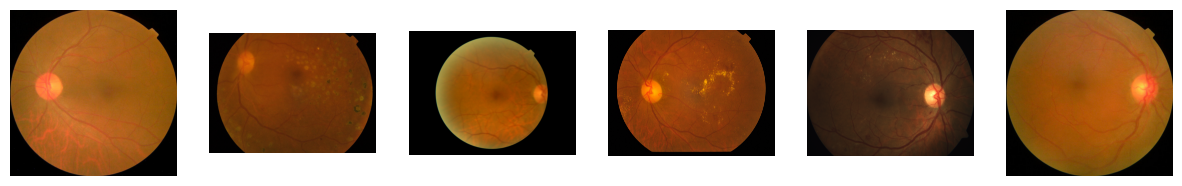

In [ ]:
# EDA: class counts and sample images
import pandas as pd, cv2, matplotlib.pyplot as plt, numpy as np, random, os, glob

df = pd.read_csv(CSV_PATH)
print("Total images:", len(df))
print("Class counts:\n", df['diagnosis'].value_counts())

# detect extension
def detect_ext(img_dir, sample_id):
    files = glob.glob(os.path.join(img_dir, sample_id + ".*"))
    return os.path.splitext(files[0])[1] if files else ".png"

ext = detect_ext(IMG_DIR, df['id_code'].iloc[0])
print("Detected extension:", ext)

# Show random sample images
def show_samples(n=6, seed=42):
    random.seed(seed)
    ids = random.sample(list(df['id_code']), n)
    plt.figure(figsize=(15,4))
    for i, idc in enumerate(ids):
        p = os.path.join(IMG_DIR, idc + ext)
        img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i+1)
        plt.imshow(img); plt.axis("off")
    plt.show()

show_samples(6)

# Crop helper & CLAHE

In [ ]:
def crop_border_rgb(img, tol=7):
    # img: RGB uint8, tol: threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = gray > tol
    if mask.any():
        coords = np.argwhere(mask)
        y0, x0 = coords.min(axis=0)
        y1, x1 = coords.max(axis=0) + 1
        return img[y0:y1, x0:x1]
    return img

def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

visually check that **cropping** & **CLAHE**

In [ ]:
import os, cv2, matplotlib.pyplot as plt

sample_id = df['id_code'].iloc[0]   # first image from CSV
ext = detect_ext(IMG_DIR, sample_id)
img_path = os.path.join(IMG_DIR, sample_id + ext)

# load image (RGB)
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
print("Original shape:", img.shape)

# crop black borders and apply CLAHE after crop
# same crop, but brighter contrast and fine blood vessels and details are clearer.
cropped = crop_border_rgb(img)
clahe_img = apply_clahe(cropped)
print("After crop shape:", cropped.shape)

Original shape: (2136, 3216, 3)
After crop shape: (2136, 2709, 3)


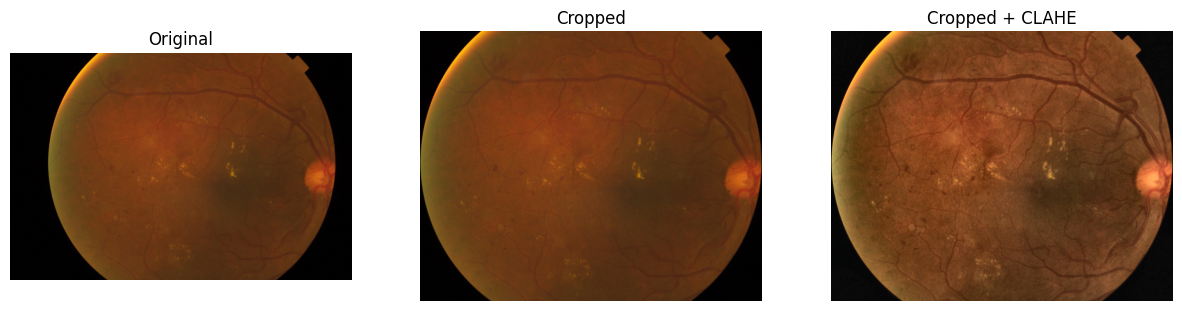

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(cropped)
plt.title("Cropped")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(clahe_img)
plt.title("Cropped + CLAHE")
plt.axis("off")

plt.show()